In [2]:
from google.colab import drive 
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Training**

In [3]:
#download pre-processing data as pkl
!gdown https://drive.google.com/uc?id=1-3H7MW6qE0LKIPHGc-gsMSshuqvwy6Q9 

Downloading...
From: https://drive.google.com/uc?id=1-3H7MW6qE0LKIPHGc-gsMSshuqvwy6Q9
To: /content/Show_Karate_norm.pkl
70.2MB [00:00, 222MB/s]


In [4]:
!gdown https://drive.google.com/uc?id=1Fcw6P8qs4wNFXm9HTZ_3fzpCzSBgHjsK   
!unzip -qq Fastpose_st_gcn.zip 

Downloading...
From: https://drive.google.com/uc?id=1Fcw6P8qs4wNFXm9HTZ_3fzpCzSBgHjsK
To: /content/Fastpose_st_gcn.zip
330MB [00:04, 81.4MB/s]


In [5]:
!wget https://github.com/GajuuzZ/Human-Falling-Detect-Tracks/raw/master/Visualizer.py

--2021-05-08 16:56:17--  https://github.com/GajuuzZ/Human-Falling-Detect-Tracks/raw/master/Visualizer.py
Resolving github.com (github.com)... 192.30.255.113
Connecting to github.com (github.com)|192.30.255.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/GajuuzZ/Human-Falling-Detect-Tracks/master/Visualizer.py [following]
--2021-05-08 16:56:17--  https://raw.githubusercontent.com/GajuuzZ/Human-Falling-Detect-Tracks/master/Visualizer.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6353 (6.2K) [text/plain]
Saving to: ‘Visualizer.py’

Visualizer.py       100%[===================>]   6.20K  --.-KB/s    in 0s      

2021-05-08 16:56:18 (75.1 MB/s) - ‘Visualizer.py’ saved [6353/6353]



In [6]:
%cd Fastpose_st_gcn 


/content/Fastpose_st_gcn


In [7]:
import os
import time
import torch
import pickle
import numpy as np
import torch.nn.functional as F
from shutil import copyfile
from tqdm import tqdm
from torch.utils import data
from torch.optim.adadelta import Adadelta
from sklearn.model_selection import train_test_split

from Actionsrecognition.Models import *
from Visualizer import plot_graphs, plot_confusion_metrix
from sklearn.metrics import plot_confusion_matrix

save_folder = '/content/drive/MyDrive/E-sport_final/Karate_output'

device = 'cuda'
epochs = 30
batch_size = 32

data_files  = '/content/drive/MyDrive/E-sport_final/Karate_output/Show_Karate_norm.pkl' 

class_names = ['Gidan_barei' ,'Mae_giri' ,'Mawashi_giri' ,'Shuto_uke' ,'Soto_uke' ,'Tseuki_Jodan' ,'Tseuki_chudan' ,'Yoko_giri']

num_class = len(class_names)

def normalize_points_with_size(xy, width, height, flip=False):
    """Normalize scale points in image with size of image to (0-1).
    xy : (frames, parts, xy) or (parts, xy)
    """
    if xy.ndim == 2:
        xy = np.expand_dims(xy, 0)
    xy[:, :, 0] /= width
    xy[:, :, 1] /= height
    if flip:
        xy[:, :, 0] = 1 - xy[:, :, 0]
    return xy


def scale_pose(xy):
    """Normalize pose points by scale with max/min value of each pose.
    xy : (frames, parts, xy) or (parts, xy)
    """
    if xy.ndim == 2:
        xy = np.expand_dims(xy, 0)
    xy_min = np.nanmin(xy, axis=1)
    xy_max = np.nanmax(xy, axis=1)
    for i in range(xy.shape[0]):
        xy[i] = ((xy[i] - xy_min[i]) / (xy_max[i] - xy_min[i])) * 2 - 1
    return xy.squeeze()
    
def load_dataset(data_files, batch_size, split_size=0):
    """Load data files into torch DataLoader with/without spliting train-test.
    """
    with open('/content/drive/MyDrive/E-sport_final/Karate_output/Show_Karate_norm.pkl', 'rb') as f:
         features, labels = pickle.load(f)

    #features = np.concatenate(features, axis=0)
    #labels   = np.concatenate(labels, axis=0)
    print(features[0].shape) 
    print(features[0].shape) 

    cv = torch.tensor(features, dtype=torch.float32) #.permute(0, 4, 3, 1, 2)
    print(cv.size())
    torch.tensor(features[0], dtype=torch.float32)
    if split_size > 0:
        x_train, x_valid, y_train, y_valid = train_test_split(features, labels)   
        train_set = data.TensorDataset(torch.tensor(x_train, dtype=torch.float32).permute(0, 3, 1, 2),
                                       torch.tensor(y_train, dtype=torch.float32))
        valid_set = data.TensorDataset(torch.tensor(x_valid, dtype=torch.float32).permute(0, 3, 1, 2),
                                       torch.tensor(y_valid, dtype=torch.float32))
        train_loader = data.DataLoader(train_set, batch_size, shuffle=True)
        valid_loader = data.DataLoader(valid_set, batch_size)
    else:
        train_set = data.TensorDataset(torch.tensor(features, dtype=torch.float32).permute(0, 3, 1, 2),
                                       torch.tensor(labels, dtype=torch.float32))
        train_loader = data.DataLoader(train_set, batch_size, shuffle=True)
        valid_loader = None
    return train_loader, valid_loader 


def accuracy_batch(y_pred, y_true):
    return (y_pred.argmax(1) == y_true.argmax(1)).mean()


def set_training(model, mode=True):
    for p in model.parameters():
        p.requires_grad = mode
    model.train(mode)
    return model


if __name__ == '__main__':
    save_folder = '/content/drive/MyDrive/E-sport_final/Karate_output'
    if not os.path.exists(save_folder):
        os.makedirs(save_folder)

    # DATA.
    train_loader, _ = load_dataset(data_files[0:1], batch_size)
    valid_loader, train_loader_ = load_dataset(data_files[0:1], batch_size, 0.2)

    train_loader = data.DataLoader(data.ConcatDataset([train_loader.dataset, train_loader_.dataset]),
                                   batch_size, shuffle=True)
    dataloader = {'train': train_loader, 'valid': valid_loader}
    del train_loader_

    # MODEL.
    graph_args = {'strategy': 'spatial'}
    model = TwoStreamSpatialTemporalGraph(graph_args, num_class).to(device)

    #optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    optimizer = Adadelta(model.parameters())

    losser = torch.nn.BCELoss()

    # TRAINING.
    loss_list = {'train': [], 'valid': []}
    accu_list = {'train': [], 'valid': []}
    for e in range(epochs):
        print('Epoch {}/{}'.format(e, epochs - 1))
        for phase in ['train', 'valid']:
            if phase == 'train':
                model = set_training(model, True)
            else:
                model = set_training(model, False)

            run_loss = 0.0
            run_accu = 0.0
            with tqdm(dataloader[phase], desc=phase) as iterator:
                for pts, lbs in iterator:
                    # Create motion input by distance of points (x, y) of the same node
                    # in two frames.
                    mot = pts[:, :2, 1:, :] - pts[:, :2, :-1, :]

                    mot = mot.to(device)
                    pts = pts.to(device)
                    lbs = lbs.to(device)

                    # Forward.
                    out = model((pts, mot))
                    loss = losser(out, lbs)

                    if phase == 'train':
                        # Backward.
                        model.zero_grad()
                        loss.backward()
                        optimizer.step()

                    run_loss += loss.item()
                    accu = accuracy_batch(out.detach().cpu().numpy(),
                                          lbs.detach().cpu().numpy())
                    run_accu += accu

                    iterator.set_postfix_str(' loss: {:.4f}, accu: {:.4f}'.format(
                        loss.item(), accu))
                    iterator.update()
                    #break
            loss_list[phase].append(run_loss / len(iterator))
            accu_list[phase].append(run_accu / len(iterator))
            #break

        print('Summary epoch:\n - Train loss: {:.4f}, accu: {:.4f}\n - Valid loss:'
              ' {:.4f}, accu: {:.4f}'.format(loss_list['train'][-1], accu_list['train'][-1],
                                             loss_list['valid'][-1], accu_list['valid'][-1]))

        # SAVE.
        torch.save(model.state_dict(), os.path.join(save_folder, 'tsstg-model.pth'))

        plot_graphs(list(loss_list.values()), list(loss_list.keys()),
                    'Last Train: {:.2f}, Valid: {:.2f}'.format(
                        loss_list['train'][-1], loss_list['valid'][-1]
                    ), 'Loss', xlim=[0, epochs],
                    save=os.path.join(save_folder, 'loss_graph.png'))
        plot_graphs(list(accu_list.values()), list(accu_list.keys()),
                    'Last Train: {:.2f}, Valid: {:.2f}'.format(
                        accu_list['train'][-1], accu_list['valid'][-1]
                    ), 'Accu', xlim=[0, epochs],
                    save=os.path.join(save_folder, 'accu_graph.png'))

        #break

    del train_loader, valid_loader

    model.load_state_dict(torch.load(os.path.join(save_folder, 'tsstg-model.pth')))

    # EVALUATION.
    model = set_training(model, False)
    data_file = data_files[1]
    eval_loader, _ = load_dataset([data_file], 32)

    print('Evaluation.')
    run_loss = 0.0
    run_accu = 0.0
    y_preds = []
    y_trues = []
    with tqdm(eval_loader, desc='eval') as iterator:
        for pts, lbs in iterator:
            mot = pts[:, :2, 1:, :] - pts[:, :2, :-1, :]
            mot = mot.to(device)
            pts = pts.to(device)
            lbs = lbs.to(device)

            out = model((pts, mot))
            loss = losser(out, lbs)

            run_loss += loss.item()
            accu = accuracy_batch(out.detach().cpu().numpy(),
                                  lbs.detach().cpu().numpy())
            run_accu += accu

            y_preds.extend(out.argmax(1).detach().cpu().numpy())
            y_trues.extend(lbs.argmax(1).cpu().numpy())

            iterator.set_postfix_str(' loss: {:.4f}, accu: {:.4f}'.format(
                loss.item(), accu))
            iterator.update()

    run_loss = run_loss / len(iterator)
    run_accu = run_accu / len(iterator)

    plot_confusion_metrix(y_trues, y_preds, class_names, 'Eval on: {}\nLoss: {:.4f}, Accu{:.4f}'.format(
        os.path.basename(data_file), run_loss, run_accu
    ), 'true', save=os.path.join(save_folder, '{}-confusion_matrix.png'.format(
        os.path.basename(data_file).split('.')[0])))

    print('Eval Loss: {:.4f}, Accu: {:.4f}'.format(run_loss, run_accu))

(30, 14, 3)
(30, 14, 3)
torch.Size([19364, 30, 14, 3])
(30, 14, 3)
(30, 14, 3)
torch.Size([19364, 30, 14, 3])


train:   0%|          | 0/757 [00:00<?, ?it/s]

Epoch 0/29


valid: 100%|██████████| 454/454 [00:15<00:00, 29.39it/s,  loss: 0.2644, accu: 0.8148]


Summary epoch:
 - Train loss: 0.1675, accu: 0.9005
 - Valid loss: 0.2977, accu: 0.7579


train:   0%|          | 1/757 [00:00<01:20,  9.36it/s,  loss: 0.1530, accu: 0.9688]

Epoch 1/29


valid: 100%|██████████| 454/454 [00:15<00:00, 29.60it/s,  loss: 0.1295, accu: 1.0000]


Summary epoch:
 - Train loss: 0.1307, accu: 0.9987
 - Valid loss: 0.1294, accu: 0.9993


train:   0%|          | 1/757 [00:00<01:25,  8.87it/s,  loss: 0.1299, accu: 1.0000]

Epoch 2/29


valid: 100%|██████████| 454/454 [00:15<00:00, 29.17it/s,  loss: 0.1276, accu: 1.0000]


Summary epoch:
 - Train loss: 0.1282, accu: 0.9995
 - Valid loss: 0.1274, accu: 1.0000


train:   0%|          | 1/757 [00:00<01:20,  9.38it/s,  loss: 0.1273, accu: 1.0000]

Epoch 3/29


valid: 100%|██████████| 454/454 [00:15<00:00, 29.56it/s,  loss: 0.3061, accu: 0.5556]


Summary epoch:
 - Train loss: 0.1278, accu: 0.9988
 - Valid loss: 0.3112, accu: 0.7005


train:   0%|          | 1/757 [00:00<01:24,  8.93it/s,  loss: 0.1435, accu: 0.9375]

Epoch 4/29


valid: 100%|██████████| 454/454 [00:15<00:00, 29.78it/s,  loss: 0.1273, accu: 1.0000]


Summary epoch:
 - Train loss: 0.1272, accu: 0.9991
 - Valid loss: 0.1265, accu: 1.0000


train:   0%|          | 1/757 [00:00<01:22,  9.19it/s,  loss: 0.1272, accu: 1.0000]

Epoch 5/29


valid: 100%|██████████| 454/454 [00:15<00:00, 29.52it/s,  loss: 0.1255, accu: 1.0000]


Summary epoch:
 - Train loss: 0.1267, accu: 0.9995
 - Valid loss: 0.1260, accu: 1.0000


train:   0%|          | 1/757 [00:00<01:21,  9.30it/s,  loss: 0.1311, accu: 1.0000]

Epoch 6/29


valid: 100%|██████████| 454/454 [00:15<00:00, 29.47it/s,  loss: 0.1254, accu: 1.0000]


Summary epoch:
 - Train loss: 0.1267, accu: 0.9991
 - Valid loss: 0.1253, accu: 1.0000


train:   0%|          | 1/757 [00:00<01:22,  9.20it/s,  loss: 0.1249, accu: 1.0000]

Epoch 7/29


valid: 100%|██████████| 454/454 [00:15<00:00, 29.40it/s,  loss: 0.1427, accu: 0.9630]


Summary epoch:
 - Train loss: 0.1259, accu: 1.0000
 - Valid loss: 0.1484, accu: 0.9453


train:   0%|          | 1/757 [00:00<01:28,  8.58it/s,  loss: 0.1803, accu: 0.8438]

Epoch 8/29


valid: 100%|██████████| 454/454 [00:15<00:00, 29.41it/s,  loss: 0.1273, accu: 1.0000]


Summary epoch:
 - Train loss: 0.1265, accu: 0.9988
 - Valid loss: 0.1277, accu: 1.0000


train:   0%|          | 1/757 [00:00<01:21,  9.23it/s,  loss: 0.1285, accu: 1.0000]

Epoch 9/29


valid: 100%|██████████| 454/454 [00:15<00:00, 29.28it/s,  loss: 0.1252, accu: 1.0000]


Summary epoch:
 - Train loss: 0.1262, accu: 0.9993
 - Valid loss: 0.1309, accu: 0.9888


train:   0%|          | 1/757 [00:00<01:21,  9.28it/s,  loss: 0.1349, accu: 0.9688]

Epoch 10/29


valid: 100%|██████████| 454/454 [00:15<00:00, 29.57it/s,  loss: 0.1253, accu: 1.0000]


Summary epoch:
 - Train loss: 0.1259, accu: 0.9995
 - Valid loss: 0.1253, accu: 1.0000


train:   0%|          | 1/757 [00:00<01:24,  8.93it/s,  loss: 0.1259, accu: 1.0000]

Epoch 11/29


valid: 100%|██████████| 454/454 [00:15<00:00, 29.67it/s,  loss: 0.1464, accu: 0.9630]


Summary epoch:
 - Train loss: 0.1256, accu: 0.9999
 - Valid loss: 0.1657, accu: 0.8770


train:   0%|          | 1/757 [00:00<01:21,  9.31it/s,  loss: 0.1349, accu: 0.9688]

Epoch 12/29


valid: 100%|██████████| 454/454 [00:15<00:00, 29.26it/s,  loss: 0.1253, accu: 1.0000]


Summary epoch:
 - Train loss: 0.1256, accu: 0.9997
 - Valid loss: 0.1253, accu: 1.0000


train:   0%|          | 1/757 [00:00<01:23,  9.07it/s,  loss: 0.1254, accu: 1.0000]

Epoch 13/29


valid: 100%|██████████| 454/454 [00:15<00:00, 29.53it/s,  loss: 0.1614, accu: 0.9630]


Summary epoch:
 - Train loss: 0.1254, accu: 1.0000
 - Valid loss: 0.2182, accu: 0.8395


train:   0%|          | 1/757 [00:00<01:24,  8.99it/s,  loss: 0.1288, accu: 1.0000]

Epoch 14/29


valid: 100%|██████████| 454/454 [00:15<00:00, 29.74it/s,  loss: 0.1248, accu: 1.0000]


Summary epoch:
 - Train loss: 0.1253, accu: 1.0000
 - Valid loss: 0.1256, accu: 1.0000


train:   0%|          | 1/757 [00:00<01:22,  9.21it/s,  loss: 0.1258, accu: 1.0000]

Epoch 15/29


valid: 100%|██████████| 454/454 [00:15<00:00, 29.73it/s,  loss: 0.1251, accu: 1.0000]


Summary epoch:
 - Train loss: 0.1254, accu: 0.9998
 - Valid loss: 0.1254, accu: 1.0000


train:   0%|          | 1/757 [00:00<01:22,  9.18it/s,  loss: 0.1267, accu: 1.0000]

Epoch 16/29


valid: 100%|██████████| 454/454 [00:15<00:00, 29.24it/s,  loss: 0.1280, accu: 1.0000]


Summary epoch:
 - Train loss: 0.1257, accu: 0.9993
 - Valid loss: 0.1292, accu: 1.0000


train:   0%|          | 1/757 [00:00<01:21,  9.25it/s,  loss: 0.1271, accu: 1.0000]

Epoch 17/29


valid: 100%|██████████| 454/454 [00:15<00:00, 29.38it/s,  loss: 0.2199, accu: 0.6667]


Summary epoch:
 - Train loss: 0.1261, accu: 0.9988
 - Valid loss: 0.2270, accu: 0.7106


train:   0%|          | 1/757 [00:00<01:21,  9.26it/s,  loss: 0.1306, accu: 1.0000]

Epoch 18/29


valid: 100%|██████████| 454/454 [00:15<00:00, 29.49it/s,  loss: 0.1253, accu: 1.0000]


Summary epoch:
 - Train loss: 0.1255, accu: 0.9998
 - Valid loss: 0.1254, accu: 1.0000


train:   0%|          | 1/757 [00:00<01:19,  9.50it/s,  loss: 0.1258, accu: 1.0000]

Epoch 19/29


valid: 100%|██████████| 454/454 [00:15<00:00, 29.58it/s,  loss: 0.1250, accu: 1.0000]


Summary epoch:
 - Train loss: 0.1260, accu: 0.9986
 - Valid loss: 0.1253, accu: 1.0000


train:   0%|          | 1/757 [00:00<01:19,  9.53it/s,  loss: 0.1255, accu: 1.0000]

Epoch 20/29


valid: 100%|██████████| 454/454 [00:15<00:00, 29.35it/s,  loss: 0.1276, accu: 1.0000]


Summary epoch:
 - Train loss: 0.1255, accu: 0.9996
 - Valid loss: 0.1269, accu: 1.0000


train:   0%|          | 1/757 [00:00<01:21,  9.28it/s,  loss: 0.1396, accu: 0.9688]

Epoch 21/29


valid: 100%|██████████| 454/454 [00:15<00:00, 29.48it/s,  loss: 0.1258, accu: 1.0000]


Summary epoch:
 - Train loss: 0.1255, accu: 0.9995
 - Valid loss: 0.1254, accu: 1.0000


train:   0%|          | 1/757 [00:00<01:24,  8.91it/s,  loss: 0.1255, accu: 1.0000]

Epoch 22/29


valid: 100%|██████████| 454/454 [00:15<00:00, 29.51it/s,  loss: 0.1252, accu: 1.0000]


Summary epoch:
 - Train loss: 0.1252, accu: 1.0000
 - Valid loss: 0.1255, accu: 1.0000


train:   0%|          | 1/757 [00:00<01:21,  9.27it/s,  loss: 0.1251, accu: 1.0000]

Epoch 23/29


valid: 100%|██████████| 454/454 [00:15<00:00, 29.27it/s,  loss: 0.1248, accu: 1.0000]


Summary epoch:
 - Train loss: 0.1255, accu: 0.9994
 - Valid loss: 0.1252, accu: 1.0000


train:   0%|          | 1/757 [00:00<01:19,  9.50it/s,  loss: 0.1256, accu: 1.0000]

Epoch 24/29


valid: 100%|██████████| 454/454 [00:15<00:00, 29.42it/s,  loss: 0.1254, accu: 1.0000]


Summary epoch:
 - Train loss: 0.1253, accu: 0.9999
 - Valid loss: 0.1255, accu: 1.0000


train:   0%|          | 1/757 [00:00<01:22,  9.21it/s,  loss: 0.1255, accu: 1.0000]

Epoch 25/29


valid: 100%|██████████| 454/454 [00:15<00:00, 29.50it/s,  loss: 0.1261, accu: 1.0000]


Summary epoch:
 - Train loss: 0.1252, accu: 1.0000
 - Valid loss: 0.1253, accu: 1.0000


train:   0%|          | 1/757 [00:00<01:23,  9.01it/s,  loss: 0.1249, accu: 1.0000]

Epoch 26/29


valid: 100%|██████████| 454/454 [00:15<00:00, 29.39it/s,  loss: 0.1320, accu: 0.9630]


Summary epoch:
 - Train loss: 0.1255, accu: 0.9993
 - Valid loss: 0.1295, accu: 0.9912


train:   0%|          | 1/757 [00:00<01:21,  9.32it/s,  loss: 0.1632, accu: 0.9062]

Epoch 27/29


valid: 100%|██████████| 454/454 [00:15<00:00, 29.38it/s,  loss: 0.1246, accu: 1.0000]


Summary epoch:
 - Train loss: 0.1254, accu: 0.9997
 - Valid loss: 0.1252, accu: 1.0000


train:   0%|          | 1/757 [00:00<01:20,  9.41it/s,  loss: 0.1245, accu: 1.0000]

Epoch 28/29


valid: 100%|██████████| 454/454 [00:15<00:00, 29.26it/s,  loss: 0.1308, accu: 1.0000]


Summary epoch:
 - Train loss: 0.1252, accu: 0.9999
 - Valid loss: 0.1388, accu: 0.9752


train:   0%|          | 1/757 [00:00<01:22,  9.11it/s,  loss: 0.1657, accu: 0.8125]

Epoch 29/29


valid: 100%|██████████| 454/454 [00:15<00:00, 29.43it/s,  loss: 0.1248, accu: 1.0000]


Summary epoch:
 - Train loss: 0.1259, accu: 0.9987
 - Valid loss: 0.1252, accu: 1.0000


eval:   0%|          | 2/606 [00:00<00:29, 20.71it/s,  loss: 0.1249, accu: 1.0000]

(30, 14, 3)
(30, 14, 3)
torch.Size([19364, 30, 14, 3])
Evaluation.


eval: 100%|██████████| 606/606 [00:20<00:00, 29.57it/s,  loss: 0.1268, accu: 1.0000]


Eval Loss: 0.1251, Accu: 1.0000


In [9]:
Image("bp.png", width=100, height=100)

NameError: ignored

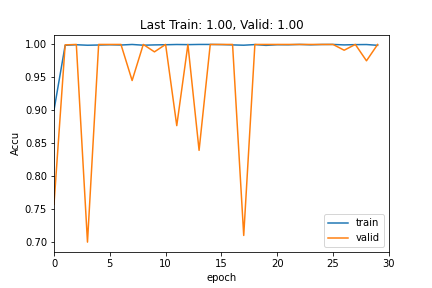

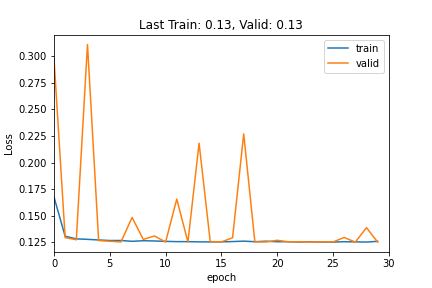

In [10]:
from IPython.display import Image, display
display(Image(os.path.join(save_folder, 'accu_graph.png')))
display(Image(os.path.join(save_folder, 'loss_graph.png')))

In [11]:
Image("bp.png", width=100, height=100)

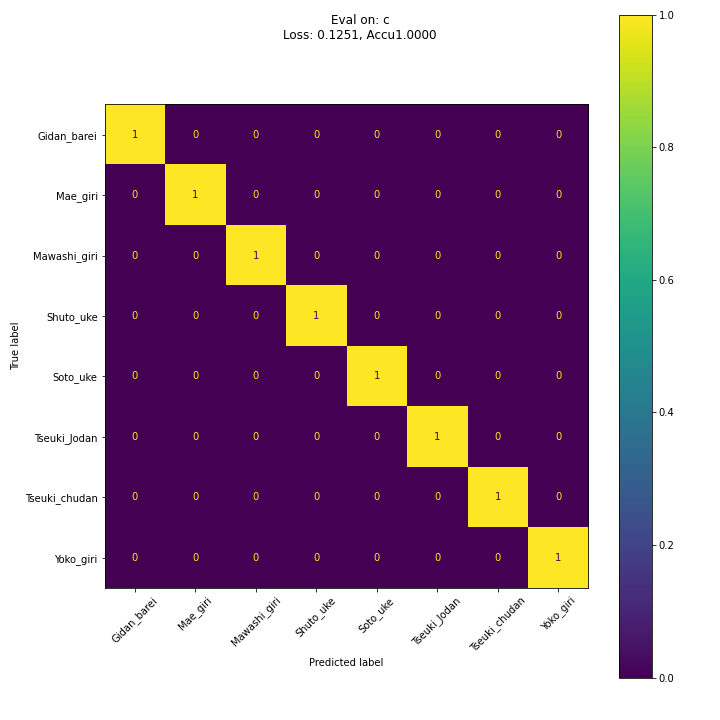

In [12]:
display(Image(os.path.join(save_folder, 'c-confusion_matrix.png')))